In [239]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

# imports:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras import metrics, objectives, losses
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [240]:
original_dim = 784
latent_dim = 2
intermediate_dim = 256
batch_size = 100
epsilon_std = 1.0

# x = Input(shape=(batch_size, original_dim))
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In plain English,

1) the encoder generates TWO ouputs: z_mean of size 2[<sup>1</sup>](#fn1) and z_log_sigma of size 2. These are not **yet** the latent representations, but the parameters of distributions from which to sample the latent representations.

2) then 2 dimensional vectors are sampled (study the **sampling** function) from a 2D-normal distribution parametrized by z_mean and K.exp(z_log_sigma). These **are** latent representations. The distribution[<sup>2</sup>](#fn2) $Q(X) \stackrel{}{\sim} \mathcal{N} (\mu, \sigma^2) $ (**NOT** the representations, from which the decoder re-creates the images) from which we sample is forced to be as close to the STANDARD normal distribution $P(X) \stackrel{}{\sim} \mathcal{N} (0, I) $ by minizing KL-divergence (see the full derivation below) between them:

$$
D_{KL}(Q||P) = -\frac{1}{2}
\sum_{j=1}^{J} \big(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2 \big)
$$

Don't worry we'll check it. By the way, why `z_mean` is not log, but `z_log_sigma` is log? I guess for simplicity of computation. We can "ask" the neural net to generate whatever we want.

#### Notes:
<span id="fn1"> You don't have to choose this size of the `latent_dim`. You can choose any number of dimensions </span>

<span id="fn2"> In fact many distributions, each different for every image fed in.</span>

#### If we don't sample from a distribution, then we get a plain autoencoder (with just a bottleck in the middle)

In [266]:
%%time
# demo:
mu = np.array([[10,-10],[-2,10]])
stdev = np.array([[1,1],[1,1]])
a = K.eval(K.random_normal(shape=(2,2), mean=mu, stddev=stdev))
print(a)

[[ 11.519464  -10.471894 ]
 [ -2.6817691  11.96275  ]]
CPU times: user 432 ms, sys: 297 ms, total: 730 ms
Wall time: 802 ms


In [267]:
batch_size = 10
a = np.random.randn(bs,2).astype('float32')
b = np.random.randn(bs,2).astype('float32')
K.eval(sampling2([a, b])).shape

(10, 2)

In [268]:
def sampling(args):
    z_mean, z_log_sigma = args
#     epsilon = K.random_normal(shape=(batch_size,latent_dim), mean=0., stddev=epsilon_std)
    epsilon = K.random_normal(shape=(latent_dim,), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon #!!!! WE NEED TO GET 2-VECTORS FROM A WHITE 2D NORMAL DISTRIBUTION
    # THE 2D NORMAL DISTRIBUTION IS PARAMETERIZED A 2-MEAN AND AND 2-LOG-SIGMA. So here we just take a random 
    # 2-vector (with mean 0 and std 1), then we offset these points from (0,0) by 
    # some std K.exp(z_log_sigma) * epsilon

def sampling2(args):
    """
    For each batch the encoder has two outputs:
    z_mean of size (batch_size, 2)
    z_log_sigma of size (batch_size, 2)
    These are parameter pairs of bivariate normal distributions, from which the sampling2 function 
    will draw 2D-points (one 2D point per each row of the batch). These 2-vectors are fed into the DECODER.
    In other words, we draw these 2D points from bivariate normal distributions P(z|x),
    each of which is conditioned on its respecitve input image x.
    """
    sample = []
    z_mean, z_log_sigma = args
    for i in range(batch_size):
        line = []
        dim1 = K.random_normal(shape=(1,), mean=z_mean[i,0], stddev=K.exp(z_log_sigma[i,0]))
        dim2 = K.random_normal(shape=(1,), mean=z_mean[i,1], stddev=K.exp(z_log_sigma[i,1]))
        line.append(dim1)
        line.append(dim2)
        line = K.stack(line, axis=1)
        sample.append(line)
    return K.reshape(K.stack(sample, axis=0), shape=(batch_size, 2))

def sampling3(args):
    """
    PERFORMANCE-OPTIMIZED VERSION OF sampling2 (see above, also a demo above)
    For each batch the encoder has two outputs:
    z_mean of size (batch_size, 2)
    z_log_sigma of size (batch_size, 2)
    These are parameter pairs of bivariate normal distributions, from which the sampling2 function 
    will draw 2D-points (one 2D point per each row of the batch). These 2-vectors are fed into the DECODER.
    In other words, we draw these 2D points from bivariate normal distributions P(z|x),
    each of which is conditioned on its respecitve input image x.
    """
    z_mean, z_log_sigma = args
    return K.random_normal(shape=(1,latent_dim), mean=z_mean, stddev=K.exp(z_log_sigma))

z = Lambda(sampling3, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [269]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [270]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [258]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
#     kl_loss = objectives.kullback_leibler_divergence(z_mean+z_log_sigma, z)
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
#     kl_loss = 0.5 * K.sum(K.square(z_log_sigma) - 1 + K.square(z_mean)/K.square(K.exp(z_log_sigma)), axis=-1)
    
#     xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
#     xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
#     kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
#     kl_loss = 0
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [259]:
vae.summary()
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 256)          200960      input_17[0][0]                   
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 2)            514         dense_43[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 2)            514         dense_43[0][0]                   
__________________________________________________________________________________________________
lambda_27 

In [260]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [261]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=4,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 59s 988us/step - loss: 168.1482 - val_loss: 160.9562
Epoch 2/4
60000/60000 [==============================] - 58s 966us/step - loss: 159.8789 - val_loss: 157.9509
Epoch 3/4
60000/60000 [==============================] - 63s 1ms/step - loss: 157.0402 - val_loss: 155.8779
Epoch 4/4
60000/60000 [==============================] - 63s 1ms/step - loss: 155.5434 - val_loss: 154.6507


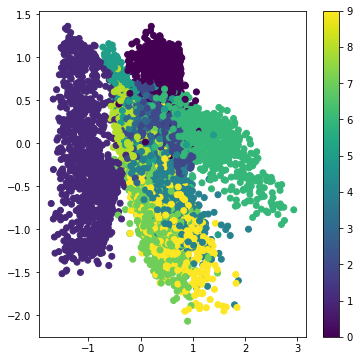

In [263]:
# x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

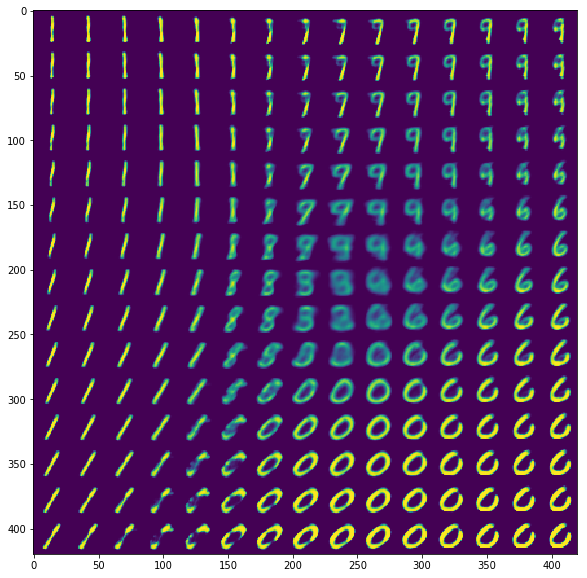

In [264]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [271]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Don't worry the explanation is below:

$$ \begin {equation}
D_{KL}(P||Q) = \int P(X) \log \frac{P(X)}{Q(X)}
\end {equation}
$$

$P(X) \stackrel{}{\sim} \mathcal{N} (\mu, \sigma^2) $ and $Q(X)\stackrel{}{\sim} \mathcal{N} (m, s^2)$ are normal distributions whose PDF is given by 
$$ \begin {equation}
PDF = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end {equation}
$$

Let's plug the PDFs into eq.1 above:

$$
\begin {equation}
\int P(X) \log \Bigg[\frac{\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}}{\frac{1}{\sqrt{2\pi s^2}} e^{-\frac{(x-m)^2}{2\sigma^2}}} \Bigg] dx
\end {equation}
$$ 

The $\frac{1}{\sqrt{2\pi}}$ cancel:

$$
\begin {equation}
\int P(X) \log \Bigg[\frac{\frac{1}{\sqrt{\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}}{\frac{1}{\sqrt{s^2}} e^{-\frac{(x-m)^2}{2\sigma^2}}} \Bigg] dx = 
\int P(X) \log \Bigg[\frac{\sqrt{s^2} e^{-\frac{(x-\mu)^2}{2\sigma^2}}}{\sqrt{\sigma^2} e^{-\frac{(x-m)^2}{2\sigma^2}}} \Bigg] dx 
\end {equation}
$$

$$
\begin {equation}
\int P(X) \Bigg[
\log \frac{\sqrt{s^2}}{\sqrt{\sigma^2}}
+
\log \frac{e^{-\frac{(x-\mu)^2}{2\sigma^2}}}{e^{-\frac{(x-m)^2}{2 s^2}}}
\Bigg] dx
\end {equation}
$$

Since the integral of a sum of summands is the sum of integrals of the summands:

$$
\begin {equation}
\int P(X) \Bigg[
\log \frac{\sqrt{s^2}}{\sqrt{\sigma^2}}
\Bigg] dx
+
\int P(X) \Bigg[
\log \frac{e^{-\frac{(x-\mu)^2}{2\sigma^2}}}{e^{-\frac{(x-m)^2}{2 s^2}}}
\Bigg] dx
\end {equation}
$$

Since $\log \frac{\sqrt{s^2}}{\sqrt{\sigma^2}}$  in $\int P(X) \Bigg[\log \frac{\sqrt{s^2}}{\sqrt{\sigma^2}}\Bigg] dx $ doesn't depend on $x$, we can take it out of the integral as a constant. The expression reduces to $\log \frac{\sqrt{s^2}}{\sqrt{\sigma^2}}$, because by definition $\int P(X)dx = 1$

**The first term in (2) therefore becomes:** $$\frac{1}{2} \log \frac{s^2}{\sigma^2}$$


The second term in **(2)** becomes:

$$
\int P(X) \Bigg[
\log {{e^{-\frac{(x-\mu)^2}{2\sigma^2}}}} - \log{{e^{-\frac{(x-m)^2}{2 s^2}}}}
\Bigg] dx
=
\int P(X) \Bigg[
-\frac{(x-\mu)^2}{2\sigma^2} + \frac{(x-m)^2}{2 s^2}
\Bigg] dx
=
\int P(X) \Bigg[
-\frac{(x-\mu)^2}{2\sigma^2}
\Bigg]
+ \int P(X) \Bigg[
\frac{(x-m)^2}{2 s^2}
\Bigg] dx
$$

The integral (or sum) of squared deviates is the variance by definition. Since we don't have data here, but only a model of the data (PDF), we can say that the integral of squared deviates of data points (from the mean) weighted by the probaility of each data point is the variance $\sigma^2$ of the data: 

$$
-\frac{1}{2 \sigma^2} 
\int P(X) \Bigg[(x-\mu)^2 \Bigg] dx + 
\frac{1}{2 s^2}\int P(X) \Bigg[(x-m)^2 \Bigg] dx
=
-\frac{\sigma^2}{2\sigma^2}
+ \frac{1}{2 s^2}\int P(X) \Bigg[(x-m)^2\Bigg] dx
=
-\frac{1}{2}
+ \frac{1}{2 s^2}\int P(X) \Bigg[(x-m)^2\Bigg] dx
$$


Now let's address the term $ \frac{1}{2 s^2}\int P(X) \big[(x-m)^2\big] dx $

expand the square by adding and subtracting $\mu$:
$$ \frac{1}{2 s^2}\int P(X) \big[(x-m)^2\big] dx =  
\frac{1}{2 s^2}\int P(X) \big[(x-\mu+\mu - m)^2\big] dx
=
\frac{1}{2 s^2}\int P(X) \big[(x-\mu)^2+(\mu-m)^2 + 2 (x-\mu)(\mu-m) \big] dx
$$


$$
\begin {equation}
\frac{1}{2 s^2}\int P(X) \big[(x-\mu)^2+(\mu-m)^2 + 2 (x-\mu)(\mu-m) \big]dx
\end {equation}
$$

$$
\begin {equation}
\frac{1}{2 s^2}\bigg[
\int (x-\mu)^2 P(X) dx +
\int (x-m)^2 P(X) dx +
\int (x-\mu)(x-m) P(X) dx +
\bigg]
\end {equation}
$$

The first term in (2) is $\sigma^2$ by definition. The second term in (2) reduces to $(\mu-m)^2$ because $(\mu-m)^2$ under the integral doesn't depend on x, we take it out of the integral (what's left $\int P(X) dx$ equals 1 by definition). The third term is zero because $(\mu-m)\int (x-m) P(X) dx$ (centered data negatives and positives sum to zero). Thus, the expression (2) can be re-written as:
$$
\frac{1}{2 s^2}\bigg[
\sigma^2 + (\mu-m)^2
\bigg]
$$

So if we put it all together:

$$\frac{1}{2} \log \frac{s^2}{\sigma^2} -
\frac{1}{2} +
\frac{1}{2 s^2}\bigg[
\sigma^2 + (\mu-m)^2
\bigg]
$$

Which is

$$\frac{1}{2} \log \frac{s^2}{\sigma^2} -
\frac{1}{2} +
\frac{\sigma^2 + (\mu-m)^2}{2 s^2}
$$

Which, if $\sigma = 1$ and $\mu=0$ is

$$\frac{1}{2}
\bigg[
\log s^2 -
1 +
\frac{m^2}{s^2}
\bigg]
$$


## Another way to derive KL-divergence

By definition of KL divergence:
$$
\begin {equation}
D_{KL}(Q||P) = \int Q(X) \log \frac{Q(X)}{P(X)}dX
\end {equation}
$$

Or, put another way:
$$
\begin {equation}
\int Q(X) \bigg[\log P(X) - \log Q(X) \bigg]dX = \int Q(X)\log P(X)dX - \int Q(X) \log Q(X)dX
\end {equation}
$$

First, let's expand $\log Q(X)$:
$$ \log Q(X) = \log \bigg[\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2 \sigma^2}}\bigg] $$
Then using the rule $\log(XY) = \log(X) + \log(Y)$

$$
\log Q(X) = \log \frac{1}{\sqrt{2\pi\sigma^2}} - \frac{(x-\mu)^2}{2 \sigma^2}
$$

### So we can compute the 1st term in (2) $\int Q(X)\log Q(X)$:

$$
\int Q(X)\log Q(X) = \int Q(X) \bigg[\log\frac{1}{\sqrt{2\pi\sigma^2}} - \frac{(x-\mu)^2}{2 \sigma^2} \bigg] dX
$$

Expand the brackets:
$$
\int Q(X)\log Q(X) = \int Q(X) \log\frac{1}{\sqrt{2\pi\sigma^2}} dX - \int Q(X) \frac{(x-\mu)^2}{2 \sigma^2} dX
$$

In the first term we take out of the integral the $\log\frac{1}{\sqrt{2\pi\sigma^2}}$ because it doesn't depend on X, what's left is equal to 1 (by the definition of normal distribution). Because $\log\frac{1}{\sqrt{2\pi\sigma^2}} = \log(1)-\log \sqrt{2\pi} + \log\sqrt{\sigma^2} = -\frac{1}{2}\log 2\pi - \frac{1}{2}\log \sigma^2$, and by definition $Var(X) = \int Q(X) (x-\mu)^2 dX = \sigma^2 $, we can write:

$$
-\frac{1}{2}\log 2\pi -\frac{1}{2}\log\sigma^2 - \frac{1}{2 \sigma^2}\sigma^2 = 
-\frac{1}{2}\log 2\pi -\frac{1}{2} + \log\sigma^2
$$
Because we have are going to have a batches of $\mu$ and $\sigma$, we need to sum over the batch length $J$:

$$\boxed{-\frac{1}{2}\log 2\pi -\frac{1}{2}\sum_{j=1}^{J} \bigg[1 + \log\sigma_j^2 \bigg]}$$

### Now let's do the second term in (2) $\int Q(X)\log P(X)dX$

First, let's take the log apart:
$$ \log P(X) = \log \bigg[\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2 \sigma^2}}\bigg] $$

Since $P(X) \stackrel{}{\sim} \mathcal{N} (0, I) $ is a normal distribution with $\mu = 0$ and $\sigma = 1$, we can write:

$$ \log P(X) = \log \bigg[\frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}\bigg] = 
-\frac{1}{2}\log 2\pi -\frac{x^2}{2}||x||^2
$$

$$\int Q(X) \bigg[ -\frac{1}{2}\log 2\pi -\frac{x^2}{2}||x||^2 \bigg]dX$$

$$-\frac{1}{2} \log 2\pi \int Q(X) dX - \frac{1}{2}\int Q(X) ||x||^2 dX
$$

Since by definition (see [Wikipedia](https://en.wikipedia.org/wiki/Variance) $Var(X) = E[X^2] - E[X]^2 = E[X^2] - \mu^2$ and $\int Q(X) ||x||^2 dX$ is the expectation of  $||X||^2$, i.e. $\int Q(X) ||x||^2 = E[X^2] = Var(X) + E[X]^2 = \sigma^2 + \mu^2 $, we can write:

$$
-\frac{1}{2}\log 2\pi - \frac{1}{2} E[X^2] = -\frac{1}{2}\log 2\pi - \frac{1}{2} E[\mu^2+\sigma^2]
$$

Since $\mu$ and $\sigma$ are vectors, we need to replace the expectation with a sum:

$$
-\frac{1}{2}\log 2\pi - \frac{1}{2} E[X^2] =$$

$$
\boxed {-\frac{1}{2}\log 2\pi - \frac{1}{2} \sum_{j=1}^{J}[\mu_j^2+\sigma_j^2]}
$$




### Finally we can put the 1st and 2nd terms together to get $D_{KL}$

$$
D_{KL}(Q||P) = -\frac{1}{2}\log 2\pi -\frac{1}{2}\sum_{j=1}^{J} \big(1 + \log\sigma_j^2 \big) - \Bigg(-\frac{1}{2}\log 2\pi - \frac{1}{2} \sum_{j=1}^{J}\big(\mu_j^2+\sigma_j^2\big) \Bigg)
$$

$$
\boxed {D_{KL}(Q||P) = -\frac{1}{2}
\sum_{j=1}^{J} \big(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2 \big)}
$$

The digit is: 6
[[0.291542   0.10259113]]


Text(0.5,1,'one meddled dec., latent->reconst')

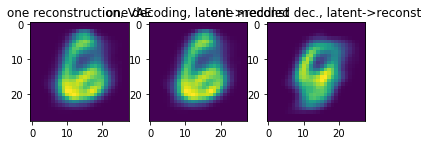

In [14]:
# print(x_test.shape)
# xx = x_test[2222,:].reshape(1,784)
# print(xx.shape)

# reconstructions = vae.predict(x_test[samp_no, :])
# print("reconstructions shape = ", reconstructions.shape)

no_samp = 3000
print("The digit is:", y_test[no_samp])
one_input = x_test[no_samp,:].reshape(1,784)
one_reconstruction = vae.predict(one_input)

plt.subplot(1,3,1)
plt.imshow(one_reconstruction.reshape(28,28))
ax = plt.gca()
ax.set_title("one reconstruction, VAE")
one_encoding = encoder.predict(one_input)
print(one_encoding)

one_decoding = generator.predict(one_encoding)
one_decoding.shape
plt.subplot(1,3,2)
plt.imshow(one_decoding.reshape(28,28))
ax1 = plt.gca()
ax1.set_title("one decoding, latent->reconst")

meddling_factor = 2000
one_meddled_decoding = generator.predict(one_encoding * np.array([-0.4]) )
plt.subplot(1,3,3)
plt.imshow(one_meddled_decoding.reshape(28,28))
ax1 = plt.gca()
ax1.set_title("one meddled dec., latent->reconst")
